In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string

%matplotlib inline

In [10]:
train = pd.read_csv("train.csv").fillna("")
train.head() 

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [11]:
train.isnull().any()

id              False
qid1            False
qid2            False
question1       False
question2       False
is_duplicate    False
dtype: bool

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404290 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [13]:
train.describe()

,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614502,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


In [14]:
foo = train.groupby(['qid1']).size().reset_index().rename(columns={0:'count'})
foo.ix[foo["count"] > 1].head()

,qid1,count
1,3,4
5,9,3
15,27,2
16,29,5
17,31,7


In [15]:
train.ix[(train["qid1"] == 31) | (train["qid2"] == 31)]

,id,qid1,qid2,question1,question2,is_duplicate
15,15,31,32,What would a Trump presidency mean for current...,How will a Trump presidency affect the student...,1
160090,160090,31,6937,What would a Trump presidency mean for current...,How will Trump’s presidency affect internation...,1
215442,215442,31,88834,What would a Trump presidency mean for current...,How would a Trump presidency affect schools ac...,1
218075,218075,31,1101,What would a Trump presidency mean for current...,How would Trump presidency affect Indian stude...,1
238721,238721,31,11435,What would a Trump presidency mean for current...,What will happen to international students in ...,1
238955,238955,31,93145,What would a Trump presidency mean for current...,Will the Trump factor affect the admission of ...,1
290679,290679,249733,31,Will international college students be negativ...,What would a Trump presidency mean for current...,1
344612,344612,44686,31,What does a Trump presidency mean for Indian s...,What would a Trump presidency mean for current...,1
364513,364513,31,12544,What would a Trump presidency mean for current...,How will Trump's presidency affect prospective...,1


In [16]:
foo = train.groupby("is_duplicate", as_index=False)['id'].count()
foo = foo.rename(columns = {list(foo)[1]: 'count'})
print(foo)

   is_duplicate   count
0             0  255027
1             1  149263


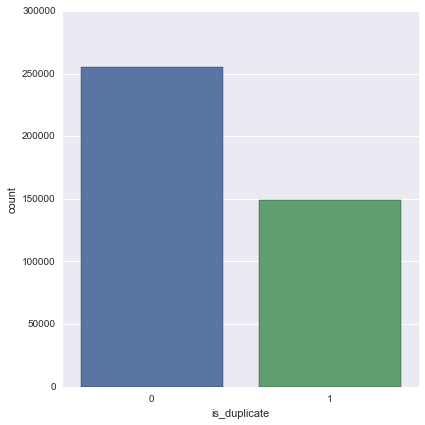

In [17]:
g = sns.factorplot(x="is_duplicate", y="count",  data=foo, kind="bar", size=6)

In [18]:
def normalized_word_share(row):
    w1 = set(map(lambda word: word, row['question1_cleaned'].split(" ")))
    w2 = set(map(lambda word: word, row['question2_cleaned'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1 | w2))

def clean_question(q, translator):
    q = q.lower().strip().translate(translator)
    return q

translator = str.maketrans('', '', string.punctuation)
train['question1_cleaned'] = train['question1'].apply(clean_question, args=(translator,))
train['question2_cleaned'] = train['question2'].apply(clean_question, args=(translator,))

train['word_share'] = train.apply(normalized_word_share, axis=1)

train.head()


,id,qid1,qid2,question1,question2,is_duplicate,question1_cleaned,question2_cleaned,word_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0.916667
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,what is the story of kohinoor kohinoor diamond,what would happen if the indian government sto...,0.285714
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0.200000
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,why am i mentally very lonely how can i solve it,find the remainder when math2324math is divide...,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0.250000


In [20]:
print(train.ix[0, 6])
print(train.ix[0, 7])

what is the step by step guide to invest in share market in india
what is the step by step guide to invest in share market


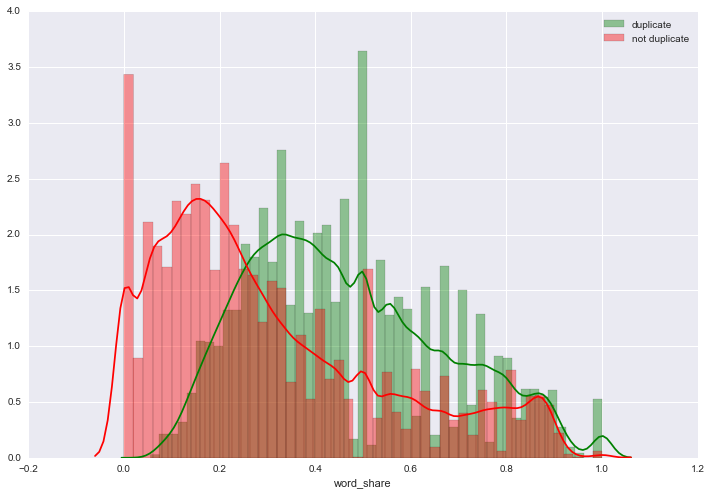

In [19]:
plt.figure(figsize=(12, 8))
sns.distplot(train.ix[train['is_duplicate'] == 1, 'word_share'], color = 'green', label="duplicate")
sns.distplot(train.ix[train['is_duplicate'] == 0, 'word_share'], color = 'red', label="not duplicate")
plt.legend()